# Tensorflow 실습 : Variational Auto-Encoder 구현

In [14]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import time

- mnist data load
  - training data만 이용

- Normalization and Binarization 
  - 0 ~ 255 값을 가진 data를 0 ~ 1로 normalization
  - 0.5 이상은 1, 미만은 0으로 값을 지정

In [15]:
# Dataset Load
mnist = tf.keras.datasets.mnist

(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28).astype('float32')

# Normalizing the images to the range of [0., 1.]
train_images /= 255.

# Binarization
train_images[train_images >= .5] = 1.
train_images[train_images < .5] = 0.

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## VAE model
- Encoder 에서 얻은 값을 둘로 나누어 각각  Decoder의 평균과 분산의 parameter 로 사용
  - logvar은 분산에 log를 씌운 값으로 취급

- 평균과 분산 값에 random normal 값을 이용하여 reparameterize

- Decoder에서는 reparameterize된 z값을 이용하여 input과 동일한 shape를 가지는 output 생성
  - sampling의 경우 sigmoid함수를 이용한 후 return
  - 학습할 때는 activation function을 이용하지 않고, logits값을 return



In [16]:
class VAE(tf.keras.Model):
    def __init__(self):
        super(VAE, self).__init__()
        self.image_dim = 784
        self.hidden_dim = 512
        self.latent_dim = 2

        self.flatten = keras.layers.Flatten(input_shape=(28,28))

        self.enc_dense_1 = keras.layers.Dense(self.hidden_dim, activation='tanh')
        self.enc_dense_2 = keras.layers.Dense(self.latent_dim * 2)

        self.dec_dense_1 = keras.layers.Dense(self.hidden_dim, activation='tanh')
        self.dec_dense_2 = keras.layers.Dense(self.image_dim)

    def encoder(self, x):
        x = self.flatten(x)
        x = self.enc_dense_1(x)
        z_before = self.enc_dense_2(x)
        mean, logvar = tf.split(z_before, num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decoder(self, z, apply_sigmoid=False):
        y = self.dec_dense_1(z)
        logits = self.dec_dense_2(y)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

vae = VAE()

- VAE에서 이미지를 생성하는 것은 decoder
  - random normal 값을 받아서 image를 생성함
- 모델을 학습하기 전, decoder를 이용하여 이미지를 생성한 결과
의미 없는 noise


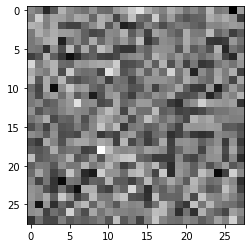

In [17]:
noise = tf.random.normal([1, 2])
generated_image = vae.decoder(noise, apply_sigmoid=True)

plt.imshow(tf.reshape(generated_image,[28,28]), cmap='gray')
plt.show()



- Adam optimizer 사용

- 이미지 출력 및 모델 checkpoint 저장 관련 코드

- noise dim은 2를 사용


In [18]:
optimizer = tf.keras.optimizers.Adam()

vae_dir = './vae'
if not os.path.exists(vae_dir):
    os.mkdir(vae_dir)
    os.mkdir(os.path.join(vae_dir,'images'))
checkpoint_dir = './vae/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer, vae=vae)

EPOCHS = 100
noise_dim = 2
num_examples_to_generate = 16

In [19]:
# We will reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

- VAE 의 loss function
- Reconstruction loss와 Regularization loss (KL Divergence loss) 로 구성

- log_normal_pdf 함수는 정규 분포 pdf 함수에 log를 취한 형태

-  ELBO를 다음과 같이 표현 가능하고, single sample Monte Carlo estimate로 추정하면 아래 식으로 변환 가능
$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right]$$


$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.


In [20]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encoder(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decoder(z)

  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=model.flatten(x))

  logpx_z = -tf.reduce_sum(cross_ent, axis=[1])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

- train step

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, train_loss):
    with tf.GradientTape() as tape:
        vae_loss = compute_loss(vae, images)
    gradients = tape.gradient(vae_loss, vae.trainable_variables)
    optimizer.apply_gradients(zip(gradients, vae.trainable_variables))
    train_loss(vae_loss)

- 매 epoch 학습 log를 출력하고, 동일한 seed를 이용하여 이미지 샘플링

In [22]:
def train(dataset, epochs):
    train_loss = tf.keras.metrics.Mean(name='train_loss')
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch, train_loss)

        generate_and_save_images(vae, epoch + 1, seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print('Time for epoch {} is {:.2f} sec and VAE Loss is {:.2f}'.format(epoch + 1,
                                                                              time.time() - start,
                                                                              train_loss.result()))

        # Reset the metrics for the next epoch
        train_loss.reset_states()

    # Generate after the final epoch
    generate_and_save_images(vae, epochs, seed, show=True)

- random seed를 이용하여, 이미지 샘플링 및 저장하는 함수


In [23]:
def generate_and_save_images(model, epoch, test_input, show=False):
    predictions = model.decoder(test_input, apply_sigmoid=True)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(tf.reshape(predictions[i], [28, 28]) * 255, cmap='gray')
        plt.axis('off')

    plt.savefig('./vae/images/image_at_epoch_{:04d}.png'.format(epoch))
    if show:
        plt.show()
    else: plt.close()

Time for epoch 1 is 1.76 sec and VAE Loss is 215.23
Time for epoch 2 is 0.97 sec and VAE Loss is 184.54
Time for epoch 3 is 0.97 sec and VAE Loss is 179.89
Time for epoch 4 is 0.97 sec and VAE Loss is 178.33
Time for epoch 5 is 0.95 sec and VAE Loss is 176.28
Time for epoch 6 is 0.97 sec and VAE Loss is 173.50
Time for epoch 7 is 0.96 sec and VAE Loss is 170.79
Time for epoch 8 is 0.96 sec and VAE Loss is 167.94
Time for epoch 9 is 0.96 sec and VAE Loss is 165.41
Time for epoch 10 is 0.96 sec and VAE Loss is 163.43
Time for epoch 11 is 0.97 sec and VAE Loss is 161.96
Time for epoch 12 is 0.96 sec and VAE Loss is 160.67
Time for epoch 13 is 0.95 sec and VAE Loss is 159.71
Time for epoch 14 is 0.94 sec and VAE Loss is 158.80
Time for epoch 15 is 0.98 sec and VAE Loss is 157.88
Time for epoch 16 is 0.95 sec and VAE Loss is 157.16
Time for epoch 17 is 3.77 sec and VAE Loss is 156.41
Time for epoch 18 is 0.95 sec and VAE Loss is 155.60
Time for epoch 19 is 0.96 sec and VAE Loss is 154.81
Ti

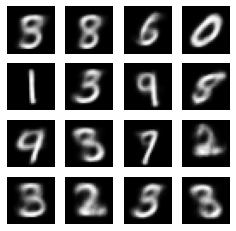

In [24]:
train(train_dataset, EPOCHS)

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

- 학습 결과 random seed로 부터, 기존 이미지와 유사한 결과를 생성할 수 있음

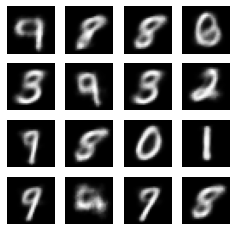

In [26]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
generate_and_save_images(vae, 999, seed, show=True)